# Bildung von Unfall-Clustern

## Initialisierung

### Import von Paketen und Definition von Funktionen

In [1]:
# Package imports
import configparser
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from esda.adbscan import ADBSCAN, get_cluster_boundary, remap_lbls
import contextily as cx

import warnings

warnings.filterwarnings("ignore")  # ignore warnings


# function definitions
def getClusters(gdf, eps, min_samples):
    adbs = ADBSCAN(eps, min_samples, pct_exact=0.5, reps=10, keep_solus=True)
    np.random.seed(1234)
    adbs.fit(gdf)
    return get_cluster_boundary(adbs.votes["lbls"], gdf, crs=gdf.crs)
  
    
def extendClusters(gdf, polys):
    # Convert GeoSeries to GeoDataFrame
    polys_gdf = gpd.GeoDataFrame(geometry=polys)
    
    # spatial join
    polys_x_acc = gpd.sjoin(gdf, polys_gdf, how='inner', predicate='intersects')
    
    # Aggregation and join
    res = polys_x_acc.groupby(['index_right'])['index_right'].count()
    polys_gdf = polys_gdf.join(res)
    polys_gdf.rename(columns={'index_right': 'accident_cnt'}, inplace=True)
  
    # determine coords
    polys_gdf['coords'] = polys_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    polys_gdf['coords'] = [coords[0] for coords in polys_gdf['coords']]
    
    return polys_gdf


def showClusters(gdf, title, figsize):
    # plot size
    plt.rcParams['figure.figsize'] = figsize
    
    # add clusters as polygons
    ax = gdf.plot(alpha=0.5, color="red")
    ax.set_title(title)
    ax.set_axis_off()
    
    # add number of accidents as polygon label
    for idx, row in gdf.iterrows():
        plt.annotate(text=row['accident_cnt'], xy=row['coords'], 
                     horizontalalignment='center', color='white', weight='bold', 
                     path_effects=[pe.withStroke(linewidth=1, foreground='black')]
                    )
    
    # add basemap
    cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
    

def exportClusters(gdf, layer_name):
    # final prep + export
    gdf.drop(['coords'], axis=1, inplace=True) 
    gdf.to_file(gpkg_cluster, layer=layer_name, driver='GPKG')
    
    
def executeClustering(gdf, eps, min_samples, title, figsize, layer_name):
    # Get clusters
    print(f'Number of accidents: {len(gdf)}')
    polys = getClusters(gdf, eps, min_samples)

    # determine cluster attributes
    clusters = extendClusters(gdf, polys)

    # Show clusters on map
    print(f'Number of clusters: {len(clusters)}')
    showClusters(clusters, title, figsize)

    # export clusters to GeoPackage
    exportClusters(clusters, layer_name)
    print(f'GeoPackage updated')

### Laden der Konfiguration aus der `config.ini`

In [2]:
rel_path = './../'

# read local config.ini file
config = configparser.ConfigParser()
config.read(rel_path + 'config.ini')

# get from config.ini
dir_output = rel_path + config['FILE_SETTINGS']['DIR_OUTPUT']
gpkg_src = dir_output + config['FILE_SETTINGS']['GPKG_NAME']
gpkg_cluster = dir_output + config['FILE_SETTINGS']['GPKG_NAME_CLU']

### Laden der Unfalldaten

Die Unfalldaten wurden in den vorherigen Workflow-Schritten verarbeitet und aufbereitet, um diese hinsichtlich des Tempolimits und der Radverkehrsanlagen analysieren zu können.

Die Daten befinden sich im dafür erstellen GeoPackage `map_data.gpkg` mit folgenden Layern:

| Layer | Daten | Beschreibung |
|:---|:---|:---|
| bike_accidents | Point (19557) | Unfalldaten nach Worfklow-Schritt 1, ohne abgeleitetes Tempolimit/RVA |
| **bike_accidents_ext** | **Point (19557)** | **Aufbereitete Unfalldaten nach Worfklow-Schritt 2, erweitert um Tempolimit/RVA** |
| fis_rva | LineString (18641) | Vorprozessierter FIS-Broker Datensatz zu RVA |
| fis_strassenabschnitte | LineString (43346) | Vorprozessierter FIS-Broker Datensatz zu Straßenabschnitten |
| fis_tempolimit | LineString (29424) | Vorprozessierter FIS-Broker Datensatz zu Tempolimits |

Es werden nur die für die Cluster-Analyse notwendigen Daten geladen, um die Verarbeitungszeit zu beschleunigen

In [3]:
# read preprocessed files
gdf = gpd.read_file(gpkg_src, layer='bike_accidents_ext', 
                   ignore_fields=['UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 
                                  'UART', 'UTYP1', 
                                  'IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstig'
                                 ])

# get coords
gdf["X"] = gdf.geometry.x
gdf["Y"] = gdf.geometry.y

# Cluster Maps

Quellenverweis: für das Erstellen der Cluster Maps wurde folgendes Tutorial verwendet und angepasst:

> ### Cluster points and explore boundary blurriness with A-DBSCAN
>
> URL: https://pysal.org/esda/notebooks/adbscan_berlin_example.html
>
> - based on PySAL ESDA (Exploratory Spatial Data Analysis) library. 
> - ESDA is an open-source Python library for the exploratory analysis of spatial data. A subpackage of PySAL (Python Spatial Analysis Library), it is under active development and includes methods for global and local spatial autocorrelation analysis.
> - pysal/esda is licensed under the BSD 3-Clause "New" or "Revised" License
>
> [PySAL: A Python Library of Spatial Analytical Methods](http://journal.srsa.org/ojs/index.php/RRS/article/view/134/85), *Rey, S.J. and L. Anselin*, Review of Regional Studies 37, 5-27 2007.

**Ablauf**: für jede Cluster Map werden die folgende Schritte durchgeführt:

1. Selektion der Daten
2. `ADBSCAN` (**A**daptive **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise), um Cluster in Form von Polygonen zu erhalten
3. Unfälle pro Polygon und Polygon-Koordinaten ermitteln
    - Ermittlung der im Polygon enthaltenen Unmfälle mittels Spatial Join (`how=inner` und `predicate=intersects`)
    - Aggregation (`groupby()` und `count()`)
4. Darstellung der Polygone auf einer Karte (inkl. Anzahl der Unfälle innerhalb des Polygons)   
5. Export als GeoPackage (eigener Layer pro Cluster Map)

## Alle Fahrradunfälle

Number of accidents: 19557
Number of clusters: 4
GeoPackage updated


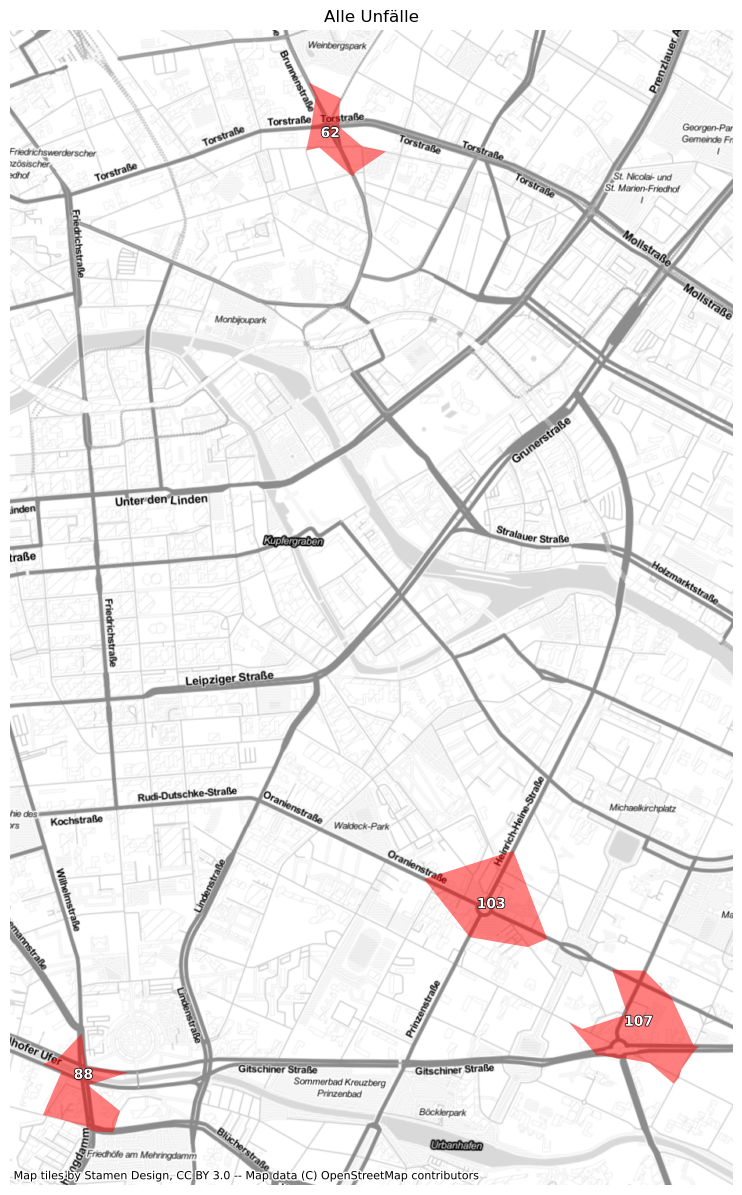

In [4]:
executeClustering(gdf, 200, 75, 'Alle Unfälle', [12, 15], 'acc_all')

## Geschwindigkeitsrelevante Fahrradunfälle auf Straßen, wo das Tempolimit mehr als 30km/h beträgt

Number of accidents: 11812
Number of clusters: 2
GeoPackage updated


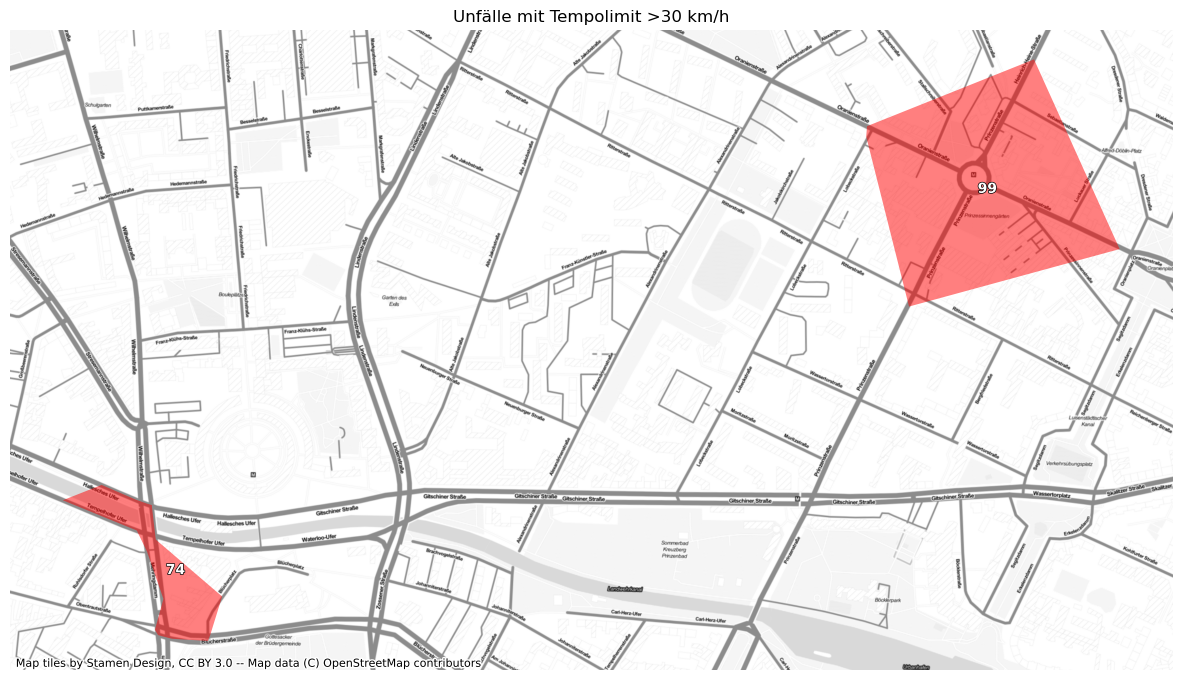

In [5]:
gdf_sel = gdf.loc[gdf['speed_rel'] & (gdf['speed_der'] > 30)]

executeClustering(gdf_sel, 200, 50, 'Unfälle mit Tempolimit >30 km/h', [15, 10], 'acc_no_speedlimit')

## Fahrradunfälle auf Straßen ohne Radverkehrsanlagen

Number of accidents: 8559
Number of clusters: 3
GeoPackage updated


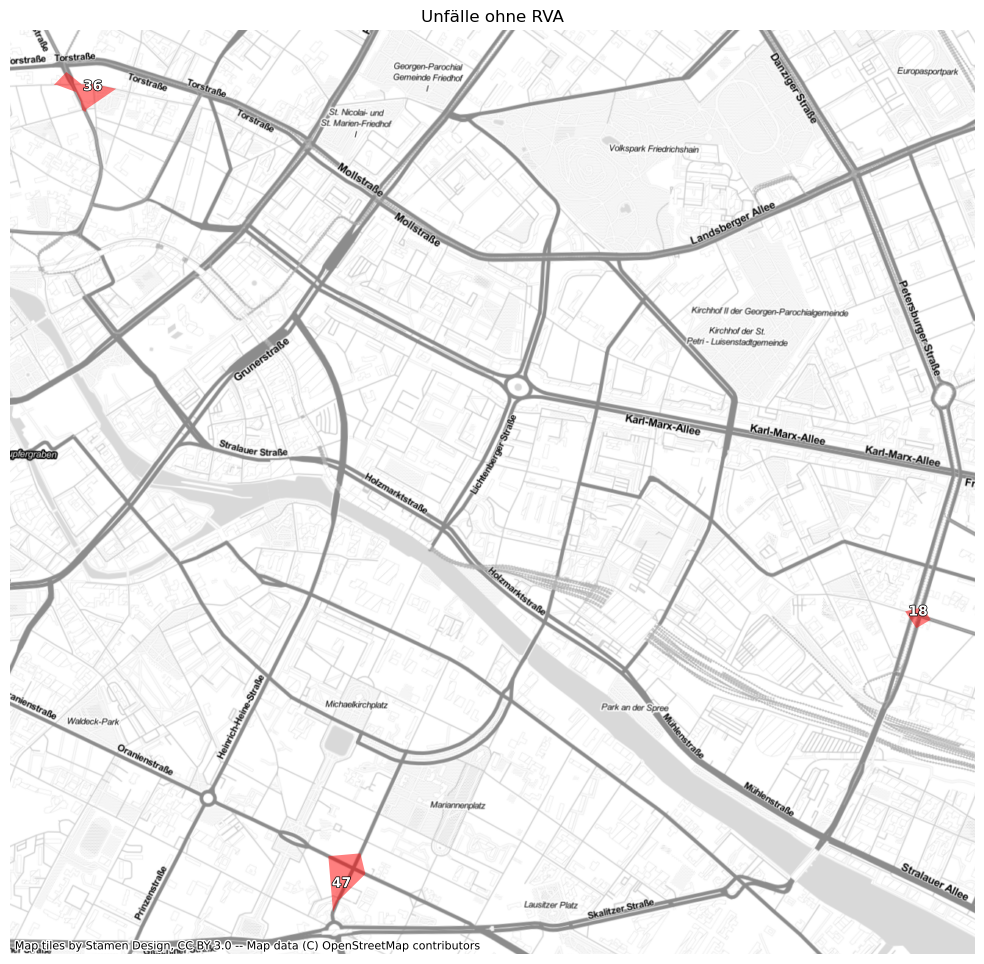

In [6]:
gdf_sel = gdf.loc[gdf['rank_rva'] == 0]

executeClustering(gdf_sel, 150, 40, 'Unfälle ohne RVA', [15, 12], 'acc_no_rva')

## Geschwindigkeitsrelevante Fahrradunfälle auf Straßen, wo das Tempolimit mehr als 30km/h beträgt und keine Radverkehrsanlagen vorhanden sind

Number of accidents: 3389
Number of clusters: 4
GeoPackage updated


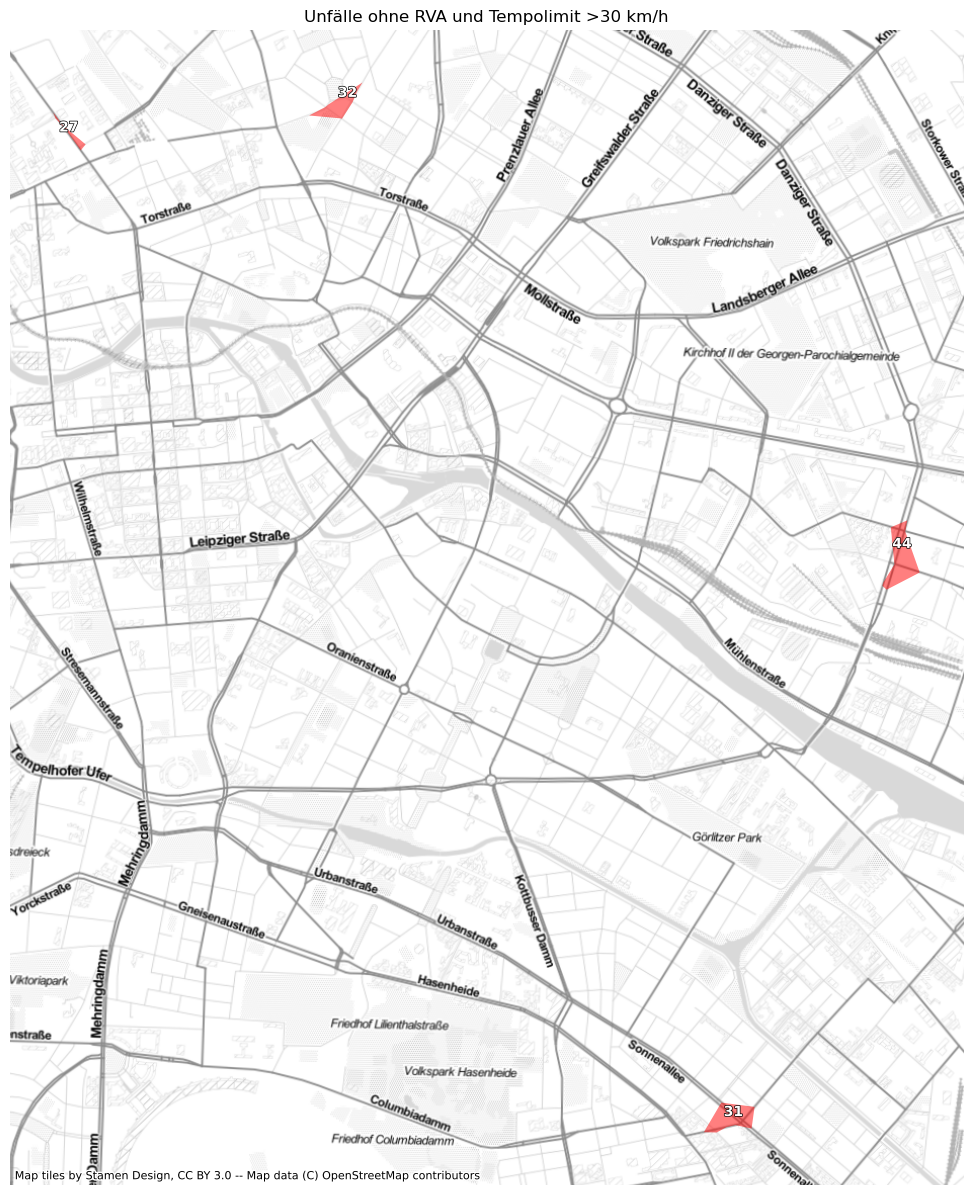

In [7]:
gdf_sel = gdf.loc[gdf['speed_rel'] & (gdf['speed_der'] > 30) & (gdf['rank_rva'] == 0)]

executeClustering(gdf_sel, 150, 25, 'Unfälle ohne RVA und Tempolimit >30 km/h', [15, 15], 'acc_no_rva_no_speed')